In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [17]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [18]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [20]:
ibm = df[df['Name'] == 'IBM'][['Close']].copy()

In [21]:
ibm['LogClose'] = np.log(ibm['Close'])

In [22]:
ibm['DiffLogClose'] = ibm['LogClose'].diff()

In [31]:
Ntest = 12
train = ibm.iloc[:-Ntest]
test = ibm.iloc[-Ntest:]

In [25]:
# Make supervised dataset

series = ibm['DiffLogClose'].to_numpy()[1:]

T = 21 # number of lags
X = [] # inputs
Y = [] # targets
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2241, 21) Y.shape (2241,)


In [26]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [27]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.00910676388568643

In [28]:
lr.score(Xtest, Ytest)

-0.10647843085489117

In [36]:
# Boolean index

train_idx = ibm.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False

In [37]:
# Need to compute un-differenced predictions

ibm['ShiftLogClose'] = ibm['LogClose'].shift(1)
prev = ibm['ShiftLogClose']

In [38]:
# Last known train value

last_train = train.iloc[-1]['LogClose']

In [39]:
# 1-step forecast

# 1-step forecast

ibm.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
ibm.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

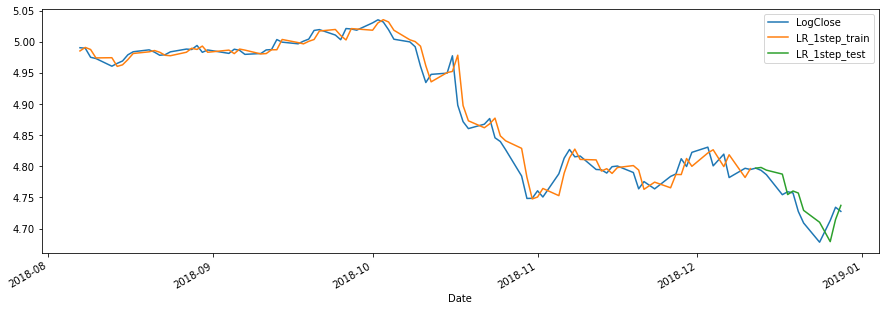

In [40]:
# Plot 1-step forecast

cols = ['LogClose', 'LR_1step_train', 'LR_1step_test']
ibm.iloc[-100:][cols].plot(figsize = (15, 5));

### Multi-step

In [41]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = lr.predict(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [42]:
# Save multi-step forecast to the dataframe

ibm.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

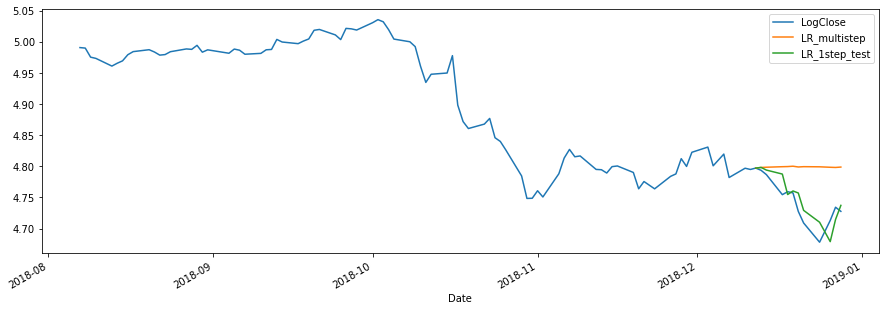

In [43]:
# Plot 1-step and multistep forecast

cols = ['LogClose', 'LR_multistep', 'LR_1step_test']
ibm.iloc[-100:][cols].plot(figsize = (15, 5));

### Multi-output

In [44]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2230, 21) Y.shape (2230, 12)


In [45]:
# Split into train and test
# 

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [46]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.010010133087048493

In [47]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

-489.9493800611111

In [48]:
# Save output to dataframe

ibm.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest_m).flatten())

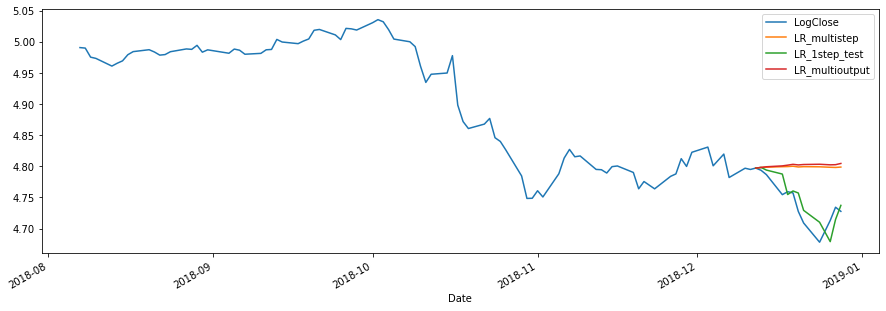

In [49]:
# Plot all

cols = ['LogClose', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
ibm.iloc[-100:][cols].plot(figsize = (15, 5)); 

In [52]:
# Use different metric

# MAPE
test_log_pass = ibm.iloc[-Ntest:]['LogClose']

mape1 = mean_absolute_percentage_error(test_log_pass, ibm.loc[test_idx, 'LR_multistep'])
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, ibm.loc[test_idx, 'LR_multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.01142632609085105
Multi-output MAPE: 0.011998190671272594


### Test Other Models

In [60]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step Forecast:", name)

  # Store 1-step forecast

  ibm.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(Xtrain)
  ibm.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(Xtest)

  # Generate multi-step forecast

  multistep_predictions = []

  # First test input

  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # Update the predictions list

    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Store multi-step forecast

  ibm.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast

  mape = mean_absolute_percentage_error(test_log_pass, ibm.loc[test_idx, f'{name}_multistep_test'])
  print('Test MAPE (multi-step):', mape)

  # Plot 1-step and multi-step forecast
  cols = ['LogClose', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
  ibm.iloc[-100:][cols].plot(figsize = (15, 5)); 

One-step Forecast: SVR
Test MAPE (multi-step): 0.009692971150318395


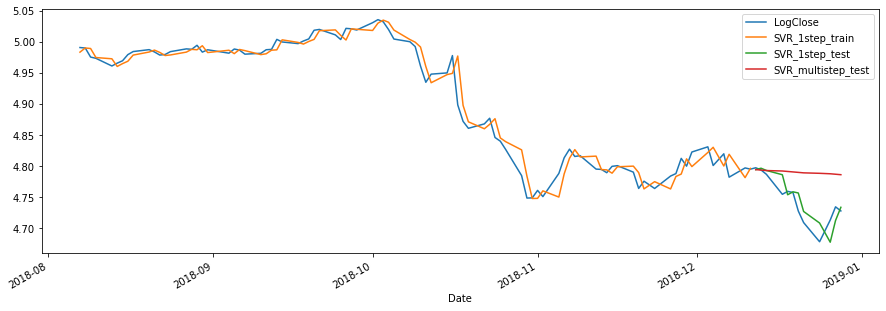

In [61]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step Forecast: RF
Test MAPE (multi-step): 0.01262083867396901


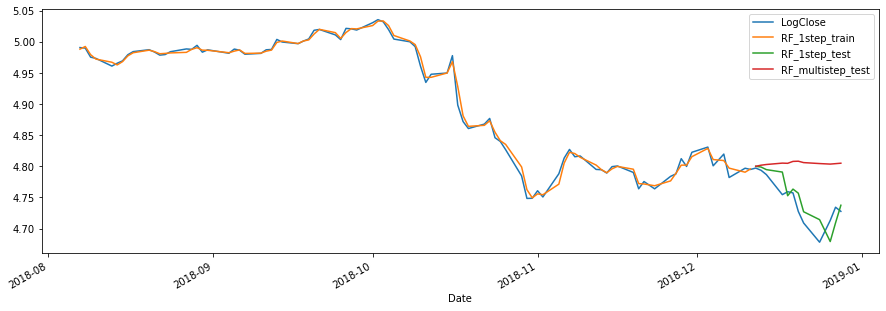

In [62]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

### Multi-output

In [66]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)

  # Store multioutput forecast to dataframe

  ibm.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(Xtest_m).flatten())

  # MAPE of multioutput forecast

  mape = mean_absolute_percentage_error(test_log_pass, ibm.loc[test_idx, f'{name}_multioutput'])
  print('Test MAPE (multioutput):', mape)

  # Plot 1-step and multi-step forecast
  cols = ['LogClose', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']
  ibm.iloc[-100:][cols].plot(figsize = (15, 5));

Test MAPE (multioutput): 0.010477118002141858


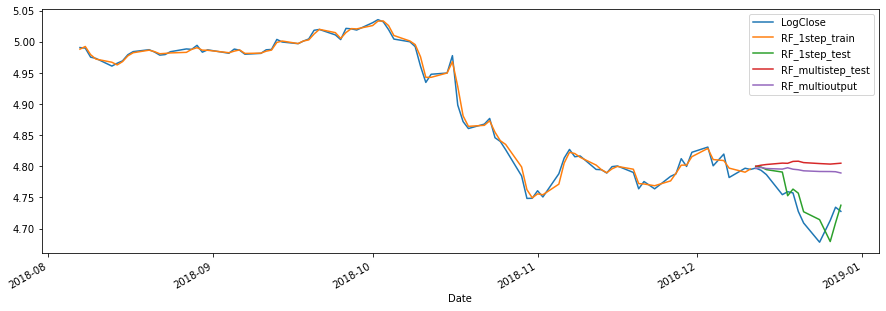

In [67]:
multi_output_forecast(RandomForestRegressor(), 'RF')